In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/pytorch/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/pytorch/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    a

In [2]:
#loading dataset

df = pd.read_csv('sentiment140.csv', encoding = 'latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df['target'].value_counts() 

target
0    800000
4    800000
Name: count, dtype: int64

In [5]:
label_map = {0:0,4:1}
df['label'] = df['target'].map(label_map)

In [6]:
#sample text cleaning
def clean_text(text):
    text = re.sub(r"https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    return text.lower()


df['clean_text'] = df['text'].apply(clean_text)
    

    

In [7]:
#train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(df['clean_text'], df['label'], test_size = 0.25, random_state=42)

In [8]:
#tokenize the dataset

from torch.nn.utils.rnn import pad_sequence
from collections import Counter

#build vocabulary
def tokenize(text):
    return text.split()

counter = Counter()
for text in train_texts:
    counter.update(tokenize(text))

vocab = {word:idx+2 for idx, (word, _) in enumerate(counter.most_common(10000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(text):
    return [vocab.get(word, vocab["<UNK>"]) for word in tokenize(text)]



class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(encode(t)) for t in texts]
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab["<PAD>"])
    return texts_padded.long(), torch.tensor(labels, dtype= torch.long)


train_dataset = SentimentDataset(train_texts, train_labels)
test_dataset  = SentimentDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, collate_fn=collate_fn)
                    

In [9]:
#create an LSTM model in PyTorch

import torch.nn as nn

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<PAD>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
            embedded = self.embedding(x)
            _, (hidden, _) = self.lstm(embedded)
            return self.fc(hidden[-1])

model = SentimentLSTM(vocab_size=len(vocab), embed_dim=128, hidden_dim=256, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.009)
        

In [10]:
#training loop

for epoch in range(10):
    model.train()
    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch : {epoch+1}, Loss: {loss.item(): .4f}')
    

Epoch : 1, Loss:  0.3908
Epoch : 2, Loss:  0.4624
Epoch : 3, Loss:  0.6684
Epoch : 4, Loss:  0.5855
Epoch : 5, Loss:  0.6765
Epoch : 6, Loss:  0.6544
Epoch : 7, Loss:  0.6451
Epoch : 8, Loss:  0.6813
Epoch : 9, Loss:  0.6872
Epoch : 10, Loss:  0.6802


In [11]:
from sklearn.metrics import classification_report

# Evaluate
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

# Explicitly set labels to match your dataset mapping
print(classification_report(
    all_labels,
    all_preds,
    labels=[0,1],
    target_names=["Negative","Positive"]
))

              precision    recall  f1-score   support

    Negative       0.54      0.45      0.49    199581
    Positive       0.53      0.62      0.57    200419

    accuracy                           0.54    400000
   macro avg       0.54      0.54      0.53    400000
weighted avg       0.54      0.54      0.53    400000



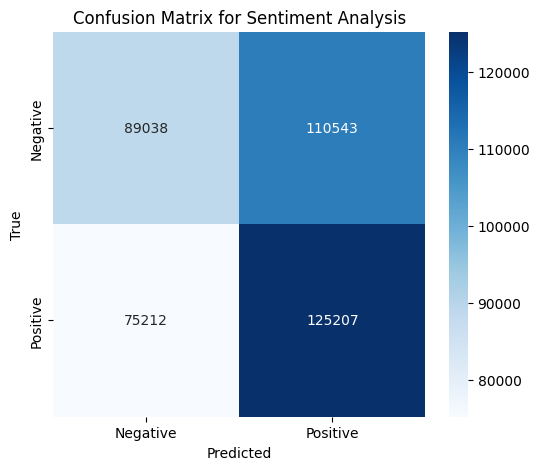

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0,1])

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Positive"],
            yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Sentiment Analysis")
plt.show()

In [17]:
import torch
import pickle

# Save both model weights and vocab together
checkpoint = {
    "model_state": model.state_dict(),
    "vocab": vocab
}

torch.save(checkpoint, "sentiment_checkpoint.pth")


In [19]:
import requests

# URL of your FastAPI endpoint
url = "http://127.0.0.1:8000/predict"

# Example text
text = "I really love this product, it's amazing!"

# Send POST request
response = requests.post(url, json=text)

# Show result
print(response.json())


{'detail': [{'type': 'model_attributes_type', 'loc': ['body'], 'msg': 'Input should be a valid dictionary or object to extract fields from', 'input': "I really love this product, it's amazing!"}]}
